In [1]:
import operator
from langgraph.graph import StateGraph,END
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage
from IPython.display import Image, display
from pydantic import BaseModel , Field
from langchain.output_parsers import PydanticOutputParser
from langchain_core.output_parsers import StrOutputParser
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_community.document_loaders import PyPDFLoader
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.tools.tavily_search import TavilySearchResults


In [2]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY1")
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
TAVILY_API_KEY=os.getenv("TAVILY_API_KEY")

# RAG Configuration

In [3]:
# Load the PDF
loader=PyPDFLoader("report.pdf")
docs=loader.load()

# print pypdf docs length
print(len(docs))

550


In [4]:
# Initialise Recusrsive Charater Text Splitter
text_splitter=RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=100
)

# Split Documents
new_docs=text_splitter.split_documents(documents=docs)
print(len(new_docs))

# Collecting all Pagecontent from new_docs
doc_string=[doc.page_content for doc in new_docs]
print(len(doc_string))

2213
2213


In [5]:
#Configure the embeddings
embeddings = HuggingFaceEmbeddings(model_name="BAAI/bge-small-en")

# Configure Chroma DB
db=Chroma.from_documents(new_docs,embeddings)

/Users/apoorvgupta/miniforge3/envs/agenticai2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Output Parser

In [7]:
# parser for Supervisor and Classifier 
class TopicSelectionParser(BaseModel):
    validation:str=Field(description="validation for clasifier")
    Reasoning:str=Field(description='Reasoning behind topic selection')

parser=PydanticOutputParser(pydantic_object=TopicSelectionParser)

parser.get_format_instructions()

'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"validation": {"description": "validation for clasifier", "title": "Validation", "type": "string"}, "Reasoning": {"description": "Reasoning behind topic selection", "title": "Reasoning", "type": "string"}}, "required": ["validation", "Reasoning"]}\n```'

# LLM

In [ ]:
#Google Gemini
model=ChatGoogleGenerativeAI(model='gemini-1.5-flash')
output=model.invoke("hi")
print(output.content)

Hi there! How can I help you today?


In [315]:
# OpenAI
model = ChatOpenAI(
    model="gpt-4o",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    # api_key="...",  # if you prefer to pass api key in directly instaed of using env vars
    # base_url="...",
    # organization="...",
    # other params...
)

# Add Node Definitions

In [316]:
# Define the Agent State Class
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [317]:
retriever=db.as_retriever(search_kwargs={"k": 10})

In [318]:
# format docs for Vector Store DB
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [319]:
def Supervisor(state : AgentState):
    print("\n---------------------------------> Supervisor ------------------------------------------->")

    messages=state["messages"]
    
    print("Message" , messages)
    
    template="""
    Your task is to classify the given user query into one of the following categories: [RAG, WebSearch, LLM]. You have to check messages.At start your ouput should be RAG. If RAG is already done in messages choose websearch. If both are done output LLM. Only respond with the category name and nothing else.

    messages : {messages}
    
    {format_instructions}
    """
    
    prompt= PromptTemplate(
        template=template,
        input_variable=["messages"],
        partial_variables={"format_instructions": parser.get_format_instructions()}
)


    chain= prompt | model | parser

    response = chain.invoke({"messages":messages})

    
    print("Parsed response:", response)
    
    return {"messages": [response.validation]}

def router_for_supervisor(state:AgentState):
    print("--------------------------------------------> ROUTER for Supervisor ------------------------->")
    
    last_message=state["messages"][-1]
    print("last_message:", last_message)
    
    if "rag" in last_message.lower():
        return "RAG Call"
    elif "websearch" in last_message.lower():
        return "WebSearch Call"
    else:
        return "LLM Call"

def WebSearchTool(state : AgentState):
    print("----------------------------------------------> Web Search Tool Call --------------------------->")

    question = state["messages"][0]

    tool=TavilySearchResults(tavily_api_key=TAVILY_API_KEY)
    result = tool.invoke({"query" : state["messages"][0]})

    a = "\n\n".join([r['content'] for r in result])

    template="""
    Your task is to extract the answer for the question from the context.
    
    Only respond with the answer and if you don't find the correct answer say i Don't know.

    question : {question}
    context : {context} 

    """
    
    prompt= PromptTemplate(
        template=template,
        input_variable=["question", "context"],
        #partial_variables={"format_instructions": parser.get_format_instructions()}
    )


    chain= prompt | model# | parser

    response = chain.invoke({"question":question, "context" : a})

    print(f"\n {question} is : {response.content}")

    return  {"messages": [response.content]}

def RAG(state : AgentState):
    print("----------------------------------------------> RAG Call ------------------------------------------->")
    
    question = state["messages"][0]
    
    prompt=PromptTemplate(
        template="""You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:""",
        
        input_variables=['context', 'question']
    )
    
    rag_chain = (
        {"context": retriever | format_docs, "question": RunnablePassthrough()}
        | prompt
        | model
        | StrOutputParser()
    )
    result = rag_chain.invoke(question)

    print("rag call result after rag_chain.invoke", result)
    
    return  {"messages": [result]}

def LLM(state : AgentState):

    print("-------------------------------------------> LLM Call -------------------------------------------------->")

    question = state["messages"][0]
    template="""
    Your task is to answer the question given by user. Only respond if you know the answer, else say I don't Know.

    User query: {question}
    {format_instructions}
    """
    
    prompt= PromptTemplate(
        template=template,
        input_variable=["question"],
        partial_variables={"format_instructions": parser.get_format_instructions()}
    )
    
    
    chain= prompt | model | parser
    
    response = chain.invoke({"question":question})
    
    print("Parsed response:", response)
    
    return {"messages": [response]}
    pass

def Classifier(state:AgentState):
    print("-------------------------------------------> Classifier ------------------------------------------------>")
    
    question=state["messages"][0]
    last_message = state["messages"][-1]
    
    print("Question",question)
    print("Last Message",last_message)

    
    template="""
    Your task is to classify the given user query into one of the following categories: [Supervisor, END]. You have to compare the question with last_message and check if it is a valid answer for the question. If the last_message satisfies the question answer END else output Supervisor. 
    
    Only respond with the category name and nothing else.

    question : {question}
    last_message : {last_message} 
    {format_instructions}
    """
    
    prompt= PromptTemplate(
        template=template,
        input_variable=["question", "last_message"],
        partial_variables={"format_instructions": parser.get_format_instructions()}
)


    chain= prompt | model | parser

    response = chain.invoke({"question":question, "last_message" : last_message})

    
    print("Parsed response:", response)
    
    return {"messages": [response.validation]}

def router_for_classifier(state:AgentState):
    print("--------------------------------------------------> ROUTER for classifier ------------------------------------>")
    
    last_message=state["messages"][-1]
    print("last_message:", last_message)
    
    if "supervisor" in last_message.lower():
        return "Supervisor Call"
    else:
        return "END Call"

def end_node(state : AgentState):
    print("-------------------------------------------------> END --------------------------------------------------------->")
    return state

# Add Nodes

In [320]:
workflow=StateGraph(AgentState)

workflow.add_node("Supervisor",Supervisor)
workflow.add_node("WebSearch",WebSearchTool)
workflow.add_node("RAG",RAG)
workflow.add_node("LLM",LLM)
workflow.add_node("Classifier",Classifier)
workflow.add_node("END", end_node)

# Add Edges

In [321]:
workflow.set_entry_point("Supervisor")
workflow.add_conditional_edges(
    "Supervisor",
    router_for_supervisor,
    {
        "RAG Call": "RAG",
        "WebSearch Call": "WebSearch",
        "LLM Call": "LLM",
    }
)
workflow.add_edge("RAG", "Classifier")
workflow.add_edge("WebSearch", "Classifier")
workflow.add_edge("LLM", "Classifier")
workflow.add_conditional_edges(
    "Classifier",
    router_for_classifier,
    {
        "Supervisor Call": "Supervisor",
        "END Call": "END",
  
    }
)
#workflow.add_edge("Classifier",END)
workflow.set_finish_point("END")

In [322]:
app=workflow.compile()

In [323]:
app.get_graph()

Graph(nodes={'__start__': Node(id='__start__', name='__start__', data=RunnablePassthrough(), metadata=None), 'Supervisor': Node(id='Supervisor', name='Supervisor', data=Supervisor(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None), 'WebSearch': Node(id='WebSearch', name='WebSearch', data=WebSearch(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None), 'RAG': Node(id='RAG', name='RAG', data=RAG(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None), 'LLM': Node(id='LLM', name='LLM', data=LLM(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None), 'Classifier': Node(id='Classifier', name='Classifier', data=Classifier(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None), 'END': Node(id='END', name='END', data=END(tags=None, recurse=True

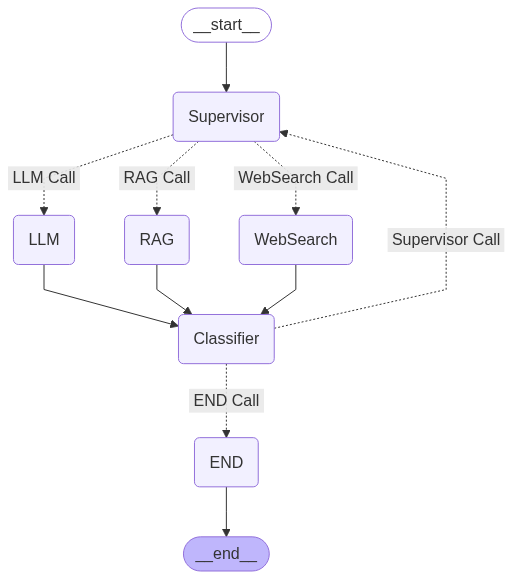

In [324]:
display(Image(app.get_graph().draw_mermaid_png()))

In [325]:
app.invoke({"messages" : ["Tata Steel Strength"]})


---------------------------------> Supervisor ------------------------------------------->
Message ['Tata Steel Strength']
Parsed response: validation='RAG' Reasoning="The query 'Tata Steel Strength' is a factual query that can be addressed using Retrieval-Augmented Generation (RAG) to provide information from a knowledge base or database. Since RAG is the initial step, it is chosen as the category."
--------------------------------------------> ROUTER for Supervisor ------------------------->
last_message: RAG
----------------------------------------------> RAG Call ------------------------------------------->
rag call result after rag_chain.invoke Tata Steel has developed a range of high-strength products, including ERW pipes with guarantees on impact toughness and resistance to hydrogen-induced cracking, and high-strength ERW tubes STK500 and STK540 for the Ahmedabad-Mumbai Bullet Train project. They have also introduced Dual Phase steels with UTS > 590 MPa and Interstitial Free st

{'messages': ['Tata Steel Strength',
  'RAG',
  'Tata Steel has developed a range of high-strength products, including ERW pipes with guarantees on impact toughness and resistance to hydrogen-induced cracking, and high-strength ERW tubes STK500 and STK540 for the Ahmedabad-Mumbai Bullet Train project. They have also introduced Dual Phase steels with UTS > 590 MPa and Interstitial Free steels with UTS > 440 MPa for automotive applications. Additionally, Tata Steel has engineered high-strength, high-ductility rebars and became the first Indian steelmaker to develop hydrogen-compliant API X65 H grade steel and pipes.',
  'END',
  'Tata Steel Strength',
  'RAG',
  'Tata Steel has developed a range of high-strength products, including ERW pipes with guarantees on impact toughness and resistance to hydrogen-induced cracking, and high-strength ERW tubes STK500 and STK540 for the Ahmedabad-Mumbai Bullet Train project. They have also introduced Dual Phase steels with UTS > 590 MPa and Interstit

In [194]:
question = "What is the most watched cartoon in India?"
last_message = "The profit after tax for Tata Steel Group in the fiscal year 2024-25 was ₹3,173.78 crore."



In [195]:
def WebSearchTool(question, last_message):
    print("-> Web Search Tool Call ->")
    tool=TavilySearchResults(tavily_api_key=TAVILY_API_KEY)
    result = tool.invoke({"query" : question})
    print(result)
    return  {"messages": [result]}

In [196]:
question="gdp of USA"
last_message = "16 Trillion"

print("Question :",question)
print("last message :",last_message)


template="""
Your task is to classify the given user query into one of the following categories: [END,Supervisor]. You have to compare the question with last_message and check if it is a valid answer for the question 
Only respond with the category name and nothing else.

question : {question}
last message : {last_message} 
{format_instructions}
"""

prompt= PromptTemplate(
    template=template,
    input_variable=["question", "last_message"],
    partial_variables={"format_instructions": parser.get_format_instructions()}
)


chain= prompt | model | parser

response = chain.invoke({"question":question, "last_message" : last_message})

print("Parsed response:", response)

Question : gdp of USA
last message : 16 Trillion
Parsed response: validation='END' Reasoning="The last message '16 Trillion' is a valid answer to the question 'gdp of USA' as it provides a numerical value that could represent the GDP of the USA."


In [297]:
nc = retriever.invoke(question)
a = "\n\n".join(doc.page_content for doc in nc)
print(a)

75 Tata Steel Nederland Technology BV EUR  0.41  376.19  1.97  67.41  -    -    1.86  67.41 
76 Tata Steel Nederland Tubes BV EUR  (0.08)  (76.87)  0.29  10.08  -    -    0.28  10.08 
77 Tata Steel Netherlands Holdings B.V. EUR  66.00  60,174.26  (66.17)  (2,263.40)  -    -    (62.30)  (2,263.40)
78 Tata Steel Norway Byggsystemer A/S NOK  0.14  130.92  0.12  4.06  -    -    0.11  4.06 
79 Tata Steel UK Consulting Limited GBP  (0.01)  (7.15)  -    -    -    -    -    -   
80 Tata Steel UK Limited GBP  (8.36)  (7,618.17)  (154.26)  (5,276.34)  14,076.67  29,880.54  677.28  24,604.20 
81 Tata Steel USA Inc. USD  0.09  86.60  0.00  0.04  -    -    0.00  0.04 
82 The Newport And South Wales Tube Company Limited GBP  0.36  326.68  -    -    -    -    -    -   
83 Thomas Processing Company USD  0.14  128.16  (0.44)  (15.18)  -    -    (0.42)  (15.18)
84 Thomas Steel Strip Corp. USD  (0.05)  (47.23)  (0.89)  (30.31)  247.78  525.97  13.64  495.66

(12) Tata Korf Engineering Services Ltd. India

In [309]:
question = "Tata Steel strength?"
last_message = "The profit after tax for Tata Steel Group in the fiscal year 2024-25 was ₹3,173.78 crore."


tool=TavilySearchResults(tavily_api_key=TAVILY_API_KEY)
result = tool.invoke({"query" : question})

a = "\n\n".join([r['content'] for r in result])

In [310]:
len(result)

5

In [311]:
a

'The strengths of tata steel are capacity expansion, self sufficiency in raw materials, strong retail and distribution, adequate internl control system, advanced\n\n# Tata Steel SWOT Analysis\n\nHere is a detailed SWOT analysis of Tata Steel covering *strengths, weaknesses, opportunities and threats*.\n\n## Tata Steel Strengths\n\nAbove are the strengths in the SWOT Analysis of Tata Steel. The strengths of Tata Steel looks at the key internal factors of its business which gives it competitive advantage in the market and strengthens its position.\n\n![](https://www.mbaskool.com/images/category/img74.jpg)\n\n![](https://www.mbaskool.com/images/category/img74.jpg) [...] | Tata Steel Overview | |\n| --- | --- |\n| Parent Company | **Tata Group** |\n| Category | Iron & steel |\n| Sector | [Industrial Products and Chemicals](/swot-analysis/industrial-products-and-chemicals.html) |\n| Tagline/ Slogan | Values stronger than steel |\n| USP | The top ten global steel companies with an annual cru

In [312]:
template="""
    Your task is to extract the answer for the question from the context.
    
    Only respond with the answer and if you don't find the correct answer say i Don't know.

    question : {question}
    context : {context} 

    """
    
prompt= PromptTemplate(
        template=template,
        input_variable=["question", "context"],
        #partial_variables={"format_instructions": parser.get_format_instructions()}
    )


chain= prompt | model# | parser

response = chain.invoke({"question":question, "context" : a})

print(f"\n {question} : {response.content}")


 Tata Steel strength? : The strengths of Tata Steel include capacity expansion, self-sufficiency in raw materials, strong retail and distribution, and an adequate internal control system.


In [313]:
response.content    

'The strengths of Tata Steel include capacity expansion, self-sufficiency in raw materials, strong retail and distribution, and an adequate internal control system.'